In [3]:
!pip install kaggle  
from google.colab import files  
files.upload()  

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soyeonchoi","key":"ff3df7a952a86f9f894540f7f39f968f"}'}

In [4]:
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/    
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d moltean/fruits

 99% 1.28G/1.28G [00:09<00:00, 139MB/s]
100% 1.28G/1.28G [00:09<00:00, 147MB/s]


In [12]:
#구글 드라이브에 캐글 데이터 다운로드
import os  
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/data/.kaggle/"   


In [16]:
from google.colab import drive  
drive.mount('/content/gdrive')  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip  
!ls

drive		    fruits-360-original-size  gdrive	   sample_data
fruits-360_dataset  fruits.zip		      kaggle.json


In [20]:
!pip install gdown

In [22]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
!pip install transformers
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 33.6 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [23]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 1
learning_rate = 5e-4

print(device)

cuda


In [24]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# Path for training and validation dataset
training_path = "/content/fruits-360_dataset/fruits-360/Training"
validating_path = "/content/fruits-360_dataset/fruits-360/Test"

In [25]:
# Create train, val dataset
training_dataset = ImageFolder(training_path,
                               transform=data_transforms)
validating_dataset = ImageFolder(validating_path,
                                 transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataloader = DataLoader(validating_dataset,
                            batch_size=batch_size,
                            shuffle=True)

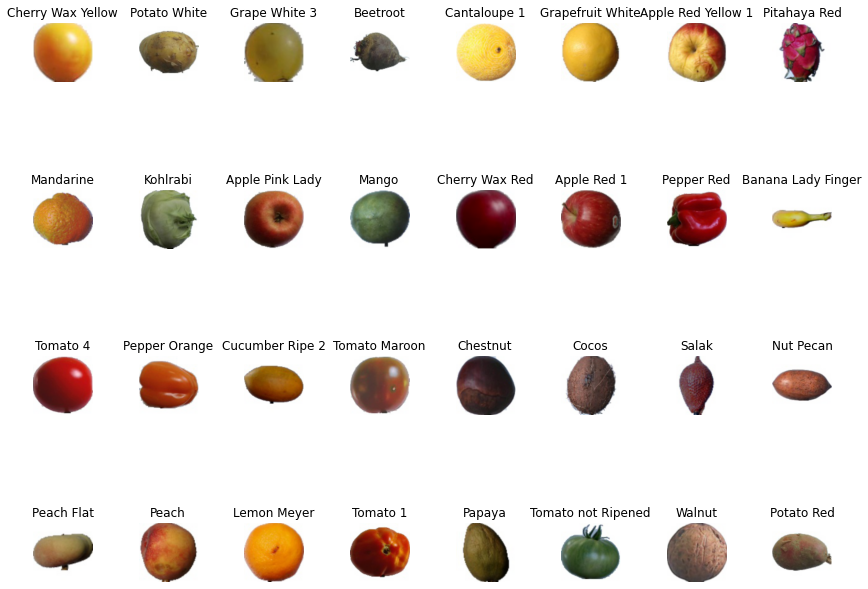

In [26]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)
    
    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

In [27]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        
        self.classes_ = classes_
        
        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output
        
        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))
        
        return outputs

In [28]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [30]:
# Create the complete model
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [31]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [32]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()
    
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Pass through the model
        outputs = model(images)
        
        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")
        
    # Set to the eval mode
    model.eval()
    
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Pass through model
            val_outputs = model(val_images)
            
            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]
            
    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))
    
    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

Batch 1 in epoch 1/1
Average loss: 4.882169246673584
Average accuracy 0.01171875
Batch 2 in epoch 1/1
Average loss: 4.794107913970947
Average accuracy 0.06640625
Batch 3 in epoch 1/1
Average loss: 4.688374996185303
Average accuracy 0.171875
Batch 4 in epoch 1/1
Average loss: 4.630577087402344
Average accuracy 0.20703125
Batch 5 in epoch 1/1
Average loss: 4.476759433746338
Average accuracy 0.3125
Batch 6 in epoch 1/1
Average loss: 4.4242939949035645
Average accuracy 0.2890625
Batch 7 in epoch 1/1
Average loss: 4.2972612380981445
Average accuracy 0.32421875
Batch 8 in epoch 1/1
Average loss: 4.20638370513916
Average accuracy 0.3359375
Batch 9 in epoch 1/1
Average loss: 4.025473117828369
Average accuracy 0.40625
Batch 10 in epoch 1/1
Average loss: 3.989661455154419
Average accuracy 0.3671875
Batch 11 in epoch 1/1
Average loss: 3.865860939025879
Average accuracy 0.38671875
Batch 12 in epoch 1/1
Average loss: 3.687223196029663
Average accuracy 0.4140625
Batch 13 in epoch 1/1
Average loss: 3

In [33]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

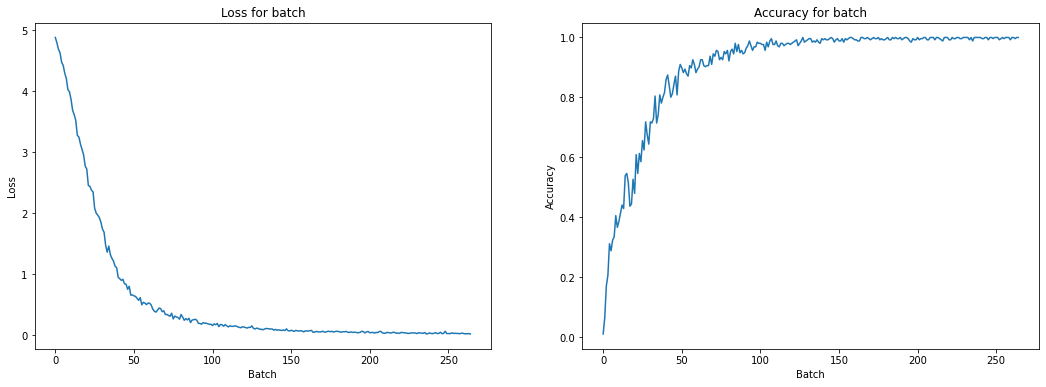

In [34]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

In [35]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        
        # Pass through model
        val_outputs = model(val_images)
        
        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [36]:
import pandas as pd

# Output dict for making the report
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [37]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
Apple Braeburn,0.895604,0.993902,0.942197,164.000000
Apple Crimson Snow,1.000000,0.986486,0.993197,148.000000
Apple Golden 1,1.000000,1.000000,1.000000,160.000000
Apple Golden 2,0.993939,1.000000,0.996960,164.000000
Apple Golden 3,0.864865,0.993789,0.924855,161.000000
Apple Granny Smith,1.000000,1.000000,1.000000,164.000000
Apple Pink Lady,0.987013,1.000000,0.993464,152.000000
Apple Red 1,0.993789,0.975610,0.984615,164.000000
Apple Red 2,0.993939,1.000000,0.996960,164.000000
Apple Red 3,1.000000,0.944444,0.971429,144.000000
